Data downloaded from https://data.mendeley.com/datasets/5cxyb5fp4f/1 
Author says the data encompasses the primary activities over a span of November 2015 to December 2018 concerning a non-life motor insurance portfolio. 

In [394]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [395]:
df = pd.read_csv('/Users/mwilson/Documents/GitHub/insurance/data/Motor vehicle insurance data.csv', sep=';')

In [396]:
# check basic information about dataset, set missing data to -1

print("Rows, columns: ", df.shape)
print("Missing entries by column")
print(df.isna().sum())
dff = df.select_dtypes(include=np.number)
df = df.fillna(-1)

Rows, columns:  (105555, 30)
Missing entries by column
ID                          0
Date_start_contract         0
Date_last_renewal           0
Date_next_renewal           0
Date_birth                  0
Date_driving_licence        0
Distribution_channel        0
Seniority                   0
Policies_in_force           0
Max_policies                0
Max_products                0
Lapse                       0
Date_lapse              70408
Payment                     0
Premium                     0
Cost_claims_year            0
N_claims_year               0
N_claims_history            0
R_Claims_history            0
Type_risk                   0
Area                        0
Second_driver               0
Year_matriculation          0
Power                       0
Cylinder_capacity           0
Value_vehicle               0
N_doors                     0
Type_fuel                1764
Length                  10329
Weight                      0
dtype: int64


In [397]:
# add some derived columns

def f(row):
    return row['Cost_claims_year']/max(1,row['N_claims_year'])
df['Cost/claim_year'] = df.apply(f, axis=1)

def f(row):
    return row['Cost_claims_year']/row['Premium']
df['Cost/prem'] = df.apply(f, axis=1)

In [398]:
# preliminary exploration

print("Number of unique vehicle, year pairs: ", df['Type_risk'].value_counts())
print("Number of unique vehicles: ", df['ID'].nunique())
print("Total number of claims in period: ", df['N_claims_year'].sum())
print("Mean cost of claims in period: ", df['Cost_claims_year'].sum()/df['N_claims_year'].sum())
print("Total cost of claims in period: ", df['Cost_claims_year'].sum())
print("Total premiums collected in period: ", df['Premium'].sum())
# assume that Date_birth, Date_driving_licence uniquely identifies customers
t = df.groupby(['Date_birth', 'Date_driving_licence'])
df['Customer_ID'] = t.ngroup()
print("Number of unique customers: ", df['Customer_ID'].nunique())

# later
# distribution of number of vehicles by customer 
#df['num_pol'] = df.groupby('Customer_ID')['ID'].transform('nunique')
#sns.histplot(data=df, x='num_pol', binwidth=100) 


Number of unique vehicle, year pairs:  Type_risk
3    82990
2    13212
1     8502
4      851
Name: count, dtype: int64
Number of unique vehicles:  53502
Total number of claims in period:  41662
Mean cost of claims in period:  389.053366857088
Total cost of claims in period:  16208741.370000001
Total premiums collected in period:  33344038.88
Number of unique customers:  47870


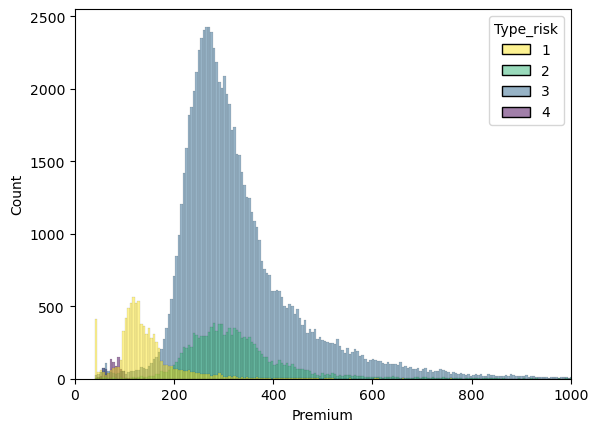

In [450]:
# premium distribution by vehicle type

sns.histplot(data=df, x="Premium", hue="Type_risk", palette='viridis_r')
plt.xlim(0, 1000)
plt.show()

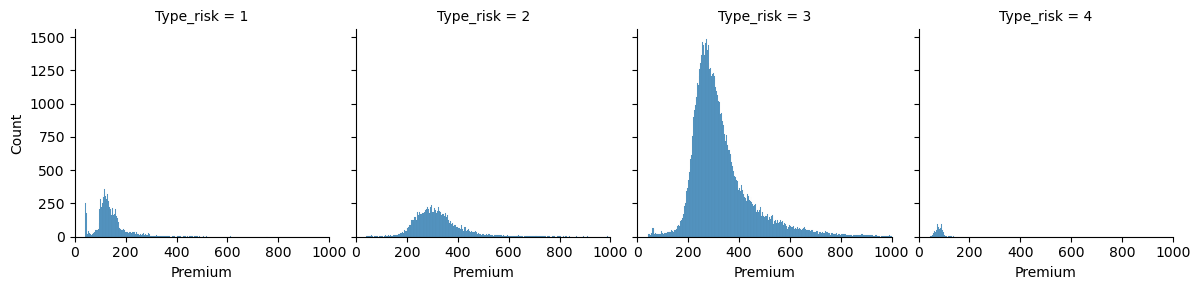

In [451]:
# same thing, separate plots

sns.displot(
        df,
        x="Premium",
        col="Type_risk",
        kind="hist",
        binwidth=3,
        height=3,
        facet_kws=dict(margin_titles=True),
    )
plt.xlim(0, 1000)
plt.show()

Now start looking at costs

Rows, columns in dataframe  (19646, 33)
Max claim:  260853.24 Median claim:  289.435 Mean claim:  825.0402814822355


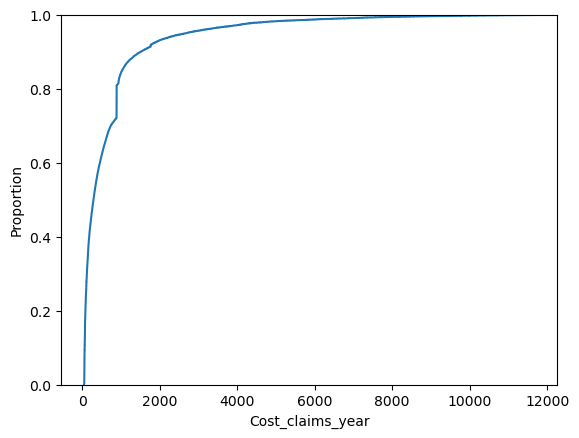

In [399]:
# expect many with cost claims  = 0, and we are right
# distribution very skewed, so cut off top 0.1% to make graph more readable

dfp = df[df['Cost_claims_year'] >0]
print("Rows, columns in dataframe ", dfp.shape)
print("Max claim: ", dfp['Cost_claims_year'].max(), "Median claim: ", dfp['Cost_claims_year'].median(),
      "Mean claim: ", dfp['Cost_claims_year'].mean())
q = df['Cost_claims_year'].quantile(0.999)
dfp = dfp[dfp['Cost_claims_year'] < q]
p = sns.ecdfplot(data=dfp, x='Cost_claims_year') # note the kink near 1000
#ax.set_title("Empirical CDF of Cost/claim_year")
plt.show()

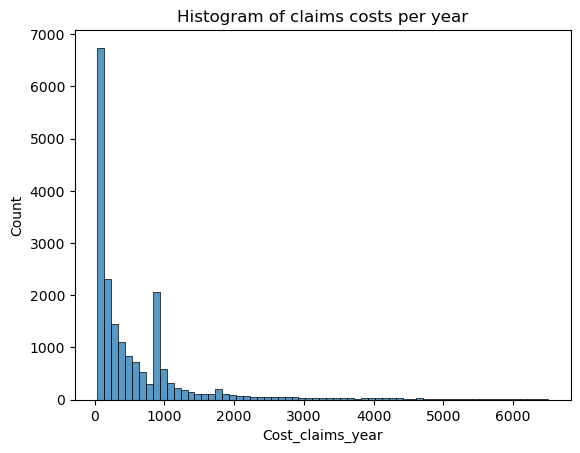

In [400]:
# histogram of cost per claim for the year (ignoring zeros)

dfp2 = dfp[dfp['Cost_claims_year'] < dfp['Cost_claims_year'].quantile(0.99)]
g = sns.histplot(data=dfp2, x='Cost_claims_year', binwidth=100) 
a = g.set_title("Histogram of claims costs per year")
# seems many claim costs are just under 1000, perhaps a payout limit enforced

In [401]:
# brief look at high value claims

df['Cost_claims_year'].nlargest(100)

55159    260853.24
63282    236285.18
95817    128809.73
92967     71968.87
44051     59656.65
           ...    
76347     12869.29
58944     12806.00
69246     12592.80
57882     12552.26
30798     12406.86
Name: Cost_claims_year, Length: 100, dtype: float64

In [417]:
# The vehicle types (1=motorbike, 2=van, 3=car, 4=agricultural vehicle) differ in claim frequency, cost/claim, cost/premium

cols = ['Cost_claims_year','N_claims_year','N_claims_history','R_Claims_history','Cost/claim_year','Type_risk','Premium','Cost/prem','Distribution_channel']
temp = df.loc[:, cols]
t = temp.groupby('Type_risk')
t.aggregate('mean')

,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Cost/claim_year,Premium,Cost/prem,Distribution_channel
Type_risk,,,,,,,,
1,36.351004,0.145378,1.603270,0.173970,25.648506,143.865193,0.259122,0.401435
2,166.345241,0.567590,3.507796,0.513436,89.510952,328.269385,0.529444,0.510067
3,165.101086,0.396747,2.768743,0.441156,93.694393,333.969194,0.494793,0.449837
4,0.226404,0.001175,0.831962,0.008484,0.226404,79.551692,0.001650,0.180964


In [418]:
# seems to be a difference between policies coming from agents versus brokers

t = temp.groupby('Distribution_channel')
t.aggregate('mean')

,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Cost/claim_year,Type_risk,Premium,Cost/prem
Distribution_channel,,,,,,,,
0,134.762863,0.365937,3.169121,0.384119,77.288360,2.724537,304.202180,0.433762
1,176.407083,0.429657,2.244343,0.475133,98.666248,2.718481,330.105403,0.527733


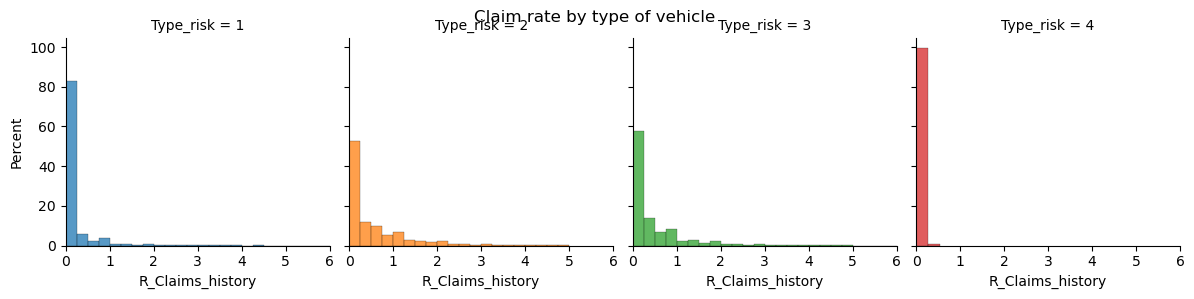

In [406]:
# now look at claim frequency

g = sns.FacetGrid(df, col="Type_risk", hue="Type_risk")
g.map(sns.histplot, "R_Claims_history", binwidth = 0.25, stat = 'percent')
g.set(xlim=(0, 6))
g.fig.suptitle("Claim rate by type of vehicle")
plt.show()

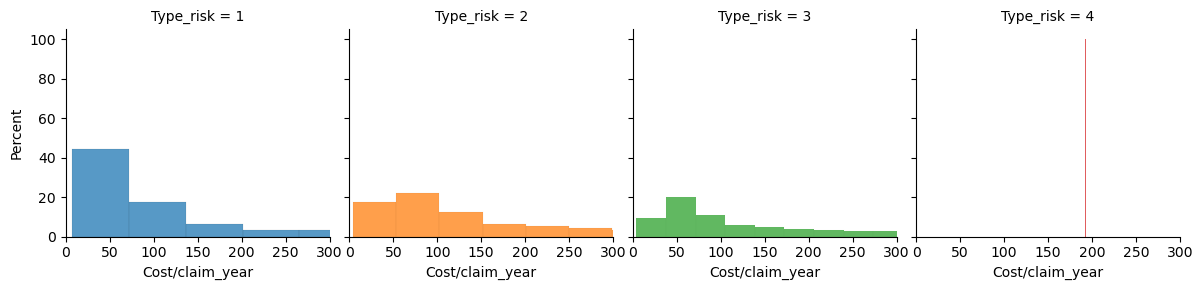

In [407]:
# cost/claim_year distribution by vehicle type, zero claims omitted since too frequent

dfp = df[df['Cost/claim_year']>0]
g = sns.FacetGrid(dfp, col="Type_risk", hue="Type_risk")
g.map(sns.histplot, "Cost/claim_year",  stat = 'percent')
g.set(xlim=(0, 300))
plt.show()

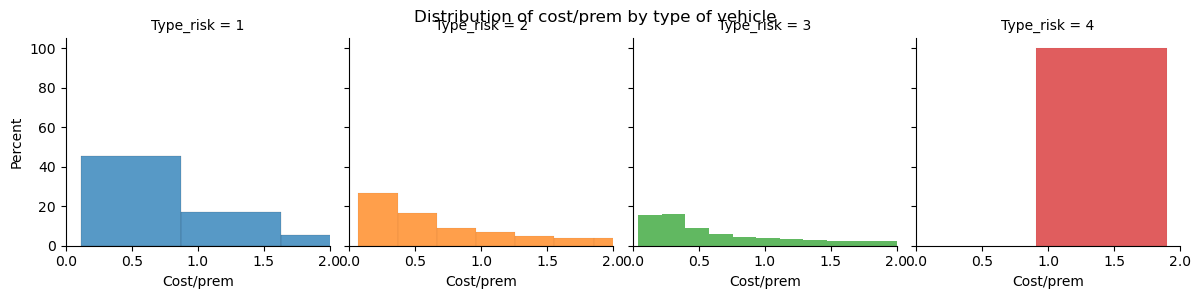

In [408]:
# cost/premium distribution by vehicle type, zero claims omitted since too frequent

dfp = df[df['Cost/prem']>0]
g = sns.FacetGrid(dfp, col="Type_risk", hue="Type_risk")
g.map(sns.histplot, "Cost/prem",stat = 'percent').fig.suptitle("Distribution of cost/prem by type of vehicle")
g.set(xlim=(0, 2))
plt.show()



In [409]:
# worth checking to see whether bad customers

df['Cost/prem'].nlargest(100)


63282    1071.248039
55159     418.194883
95817     358.402142
6073      188.982252
51361     177.481005
            ...     
42408      39.470691
86962      39.398935
42585      39.141671
49161      38.933954
76347      38.715111
Name: Cost/prem, Length: 100, dtype: float64

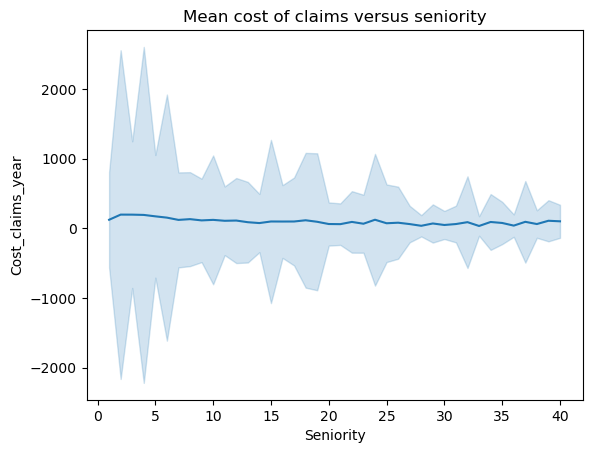

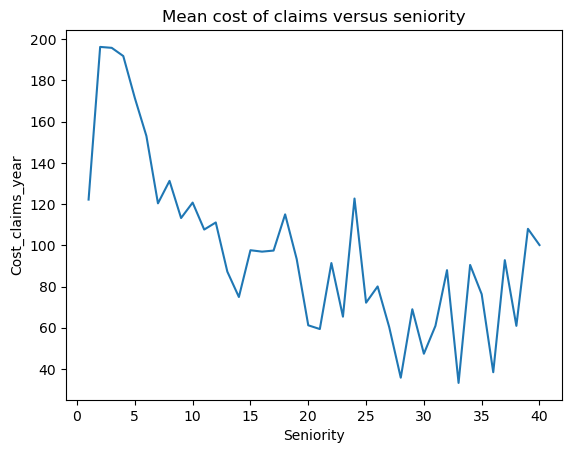

In [421]:
# claim costs by seniority (length of time having a policy with company)

cols = ['Seniority',  'Cost_claims_year','N_claims_year','N_claims_history','R_Claims_history','Distribution_channel','Cost/claim_year','Cost/prem']
temp = df.loc[:, cols]
temp = temp.groupby('Seniority')
t = temp.aggregate('mean')
sns.lineplot(df, x='Seniority',y='Cost_claims_year',errorbar='sd').set_title("Mean cost of claims versus seniority")
plt.show()
sns.lineplot(t, x='Seniority',y='Cost_claims_year').set_title("Mean cost of claims versus seniority")
plt.show()

In [422]:
df['Date_birth'] = pd.to_datetime(df['Date_birth'], format='%d/%m/%Y')
df['Date_start_contract'] = pd.to_datetime(df['Date_start_contract'], format='%d/%m/%Y')
df['Date_last_renewal'] = pd.to_datetime(df['Date_last_renewal'], format='%d/%m/%Y')
df['Date_next_renewal'] = pd.to_datetime(df['Date_next_renewal'], format='%d/%m/%Y')
df['Date_driving_licence'] = pd.to_datetime(df['Date_driving_licence'], format='%d/%m/%Y')
df['Age'] = (df['Date_last_renewal'] - df['Date_birth'])
df['Age2'] = pd.to_timedelta(df.Age, errors='coerce').dt.days//365
df['Experience'] = df['Date_last_renewal'] - df['Date_driving_licence']
df['Experience2'] = pd.to_timedelta(df['Date_last_renewal'] - df['Date_driving_licence']).dt.days//365

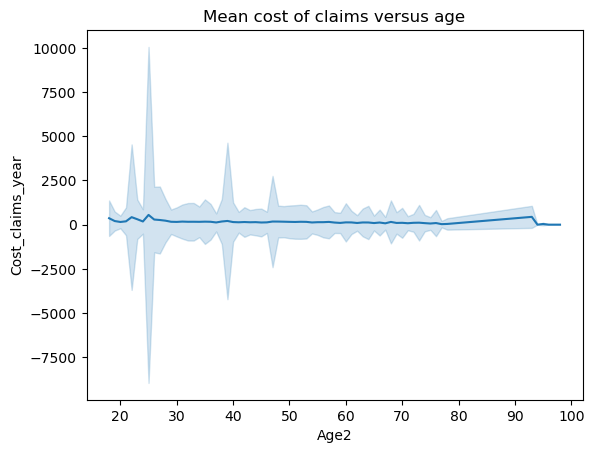

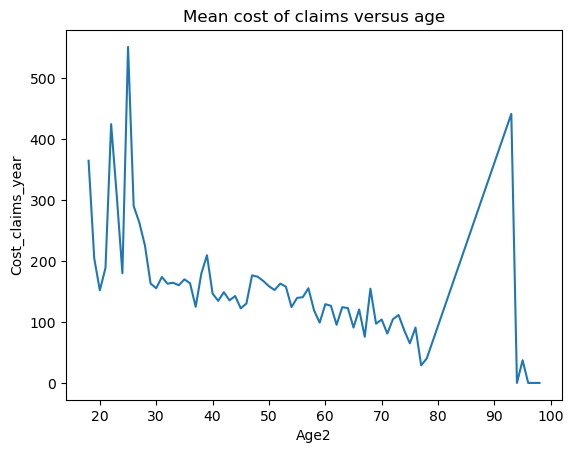

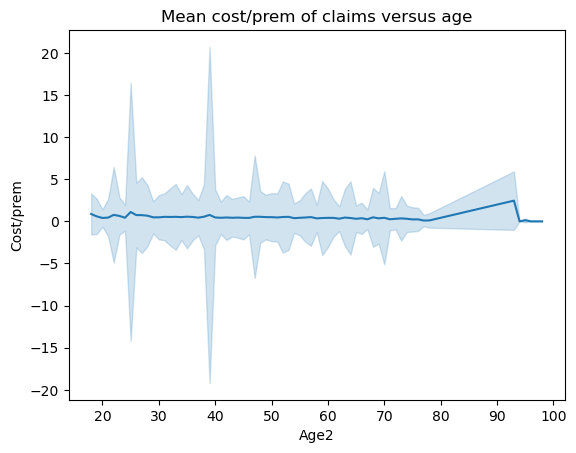

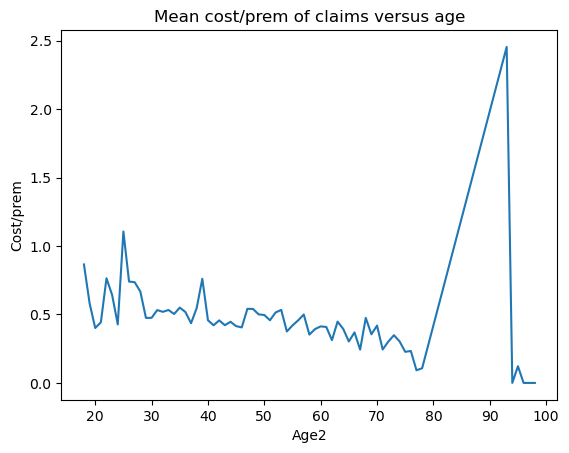

In [423]:
# claim costs by age 

cols = ['Age','Age2',  'Cost_claims_year','N_claims_year','N_claims_history','R_Claims_history','Distribution_channel','Cost/claim_year','Cost/prem']
temp = df.loc[:, cols]
temp = temp.groupby('Age2')
t = temp.aggregate('mean')
#sns.histplot(df, x='Age',y='Cost_claims_year').set_title("Mean cost of claims versus age")
#plt.show()
#sns.histplot(t, x='Age',y='Cost_claims_year').set_title("Mean cost of claims versus age")
#plt.show()
sns.lineplot(df, x='Age2',y='Cost_claims_year',errorbar='sd').set_title("Mean cost of claims versus age")
plt.show()
sns.lineplot(t, x='Age2',y='Cost_claims_year').set_title("Mean cost of claims versus age")
plt.show()
sns.lineplot(df, x='Age2',y='Cost/prem',errorbar='sd').set_title("Mean cost/prem of claims versus age")
plt.show()
sns.lineplot(t, x='Age2',y='Cost/prem').set_title("Mean cost/prem of claims versus age")
plt.show()

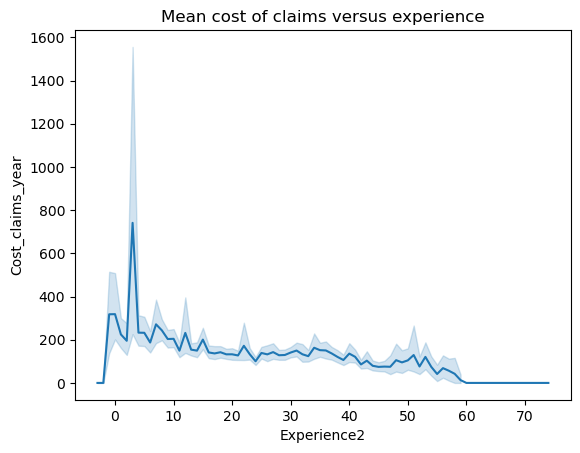

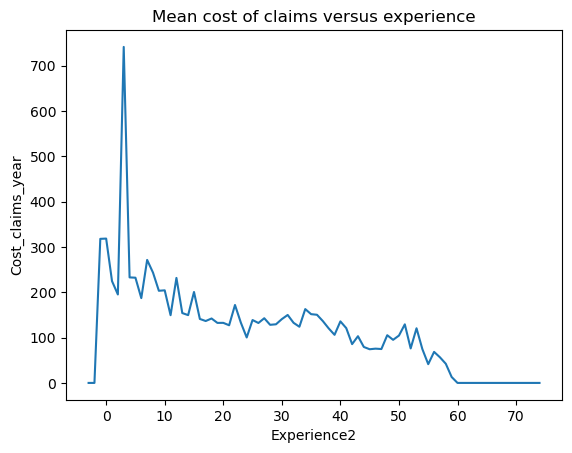

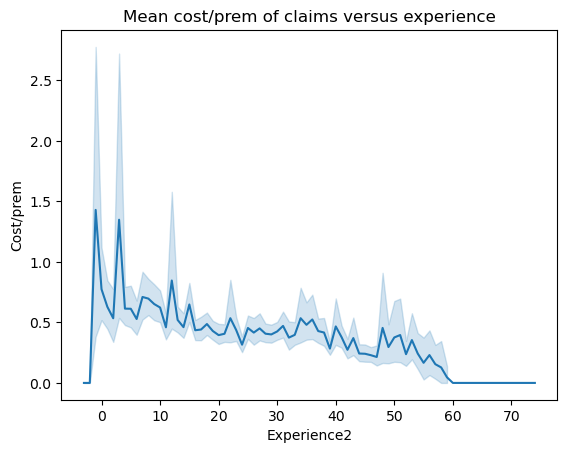

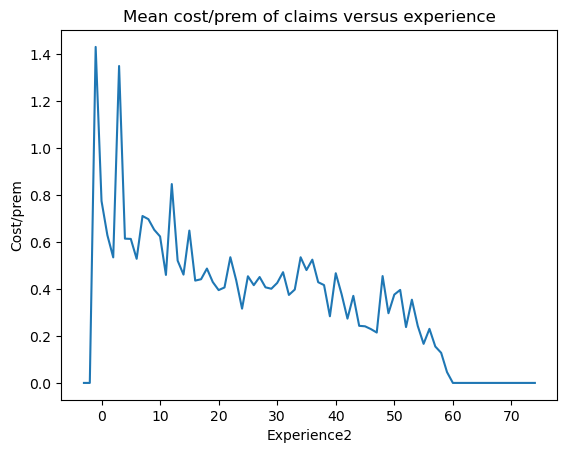

In [424]:
# claim costs by experience 
# relatively inexperienced drivers have cost more than expected

cols = ['Experience', 'Experience2', 'Cost_claims_year','N_claims_year','N_claims_history','R_Claims_history','Distribution_channel','Cost/claim_year','Cost/prem']
temp = df.loc[:, cols]
temp = temp.groupby('Experience2')
t = temp.aggregate('mean')
sns.lineplot(df, x='Experience2',y='Cost_claims_year').set_title("Mean cost of claims versus experience")
plt.show()
sns.lineplot(t, x='Experience2',y='Cost_claims_year').set_title("Mean cost of claims versus experience")
plt.show()
sns.lineplot(df, x='Experience2',y='Cost/prem').set_title("Mean cost/prem of claims versus experience")
plt.show()
sns.lineplot(t, x='Experience2',y='Cost/prem').set_title("Mean cost/prem of claims versus experience")
plt.show()

In [428]:
# units that cost more than their premium in that year
# around 9% of them - any drivers repeatedly involved?
# note several claims in a given year for some drivers

dfe = df[df['Cost/prem'] > 1]
dfe.shape
cols = ['Distribution_channel', 'Cost_claims_year','N_claims_year','N_claims_history','R_Claims_history','Cost/prem','Type_risk','Customer_ID', 'Seniority']
temp = dfe.loc[:, cols]
t = temp.sort_values(by=['Cost/prem','R_Claims_history'],ascending=False)
print(t.shape)
t.head(10)

(9388, 9)


,Distribution_channel,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Cost/prem,Type_risk,Customer_ID,Seniority
63282,0,236285.18,2,2,2.00,1071.248039,3,4240,4
55159,1,260853.24,3,3,3.00,418.194883,3,43545,2
95817,0,128809.73,3,3,0.54,358.402142,3,4506,6
6073,0,13948.78,1,11,1.60,188.982252,2,41714,9
51361,1,21677.53,2,3,2.00,177.481005,2,39544,2
36810,0,22098.66,1,3,1.01,161.127670,1,15962,8
25162,1,29255.91,3,3,1.50,149.097493,3,20764,3
60873,0,50101.94,5,6,4.99,146.642686,3,5399,2
8340,1,9336.61,2,4,1.32,143.928010,3,34884,17
44051,0,59656.65,3,5,2.81,124.796875,3,20866,2


In [468]:
temp = df.loc[:, cols]
t = temp.groupby('Customer_ID')['Cost_claims_year'].aggregate('mean').sort_values(ascending=False)
t.head(10)

Customer_ID
4240     236285.180
43545    130426.620
4506     128809.730
20866     59656.650
5399      50101.940
29167     48546.770
27822     40658.480
38353     39281.100
1997      35984.435
1206      35191.030
Name: Cost_claims_year, dtype: float64

In [469]:
t = temp.groupby('Customer_ID')['Cost_claims_year'].aggregate('sum').sort_values(ascending=False)
t.head(10)

Customer_ID
43545    260853.24
4240     236285.18
4506     128809.73
1997      71968.87
20866     59656.65
5399      50101.94
29167     48546.77
27822     40658.48
38353     39281.10
22956     37469.28
Name: Cost_claims_year, dtype: float64

In [467]:
# how many customers have multiple bad years? not that many, it seems
dfe[dfe['Customer_ID'].groupby(dfe['Customer_ID']).transform('size')>1]
# of course, it is possible that some drivers were not insured again after particularly bad years

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Distribution_channel,Seniority,Policies_in_force,Max_policies,...,Type_fuel,Length,Weight,Cost/claim_year,Cost/prem,Customer_ID,Age,Age2,Experience,Experience2
88,39,2012-10-15,2017-10-15,2018-10-15,1961-10-19,1985-09-02,1,7,1,1,...,P,4.020,1020,142.428571,2.739764,30845,20450 days,56,11731 days,32
89,39,2012-10-15,2018-10-15,2019-10-15,1961-10-19,1985-09-02,1,7,1,1,...,P,4.020,1020,886.432500,7.298594,30845,20815 days,57,12096 days,33
168,83,2016-07-08,2016-07-08,2017-07-08,1979-01-15,1998-10-15,0,3,2,3,...,D,4.276,1290,287.606000,4.463437,23200,13689 days,37,6476 days,17
169,83,2016-07-08,2017-07-08,2018-07-08,1979-01-15,1998-10-15,0,3,3,3,...,D,4.276,1290,565.800000,1.705039,23200,14054 days,38,6841 days,18
196,98,2012-03-19,2016-03-15,2017-03-15,1965-06-16,1984-06-29,1,7,1,3,...,D,4.342,1388,220.500000,3.286018,25789,18535 days,50,11582 days,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104821,53054,2015-10-19,2017-10-19,2018-10-19,1978-09-04,1996-11-22,1,5,1,2,...,D,4.365,1420,882.000000,1.363594,7575,14290 days,39,7636 days,20
104835,53066,2016-05-12,2016-05-12,2017-05-12,1980-01-23,1998-01-23,1,3,1,1,...,D,4.180,1350,294.000000,3.344583,35696,13259 days,36,6684 days,18
104836,53066,2016-05-12,2017-05-12,2018-05-12,1980-01-23,1998-01-23,1,3,1,1,...,D,4.180,1350,2623.605000,18.772217,35696,13624 days,37,7049 days,19
104961,53132,2016-04-12,2016-04-12,2017-04-12,1989-08-28,2008-03-12,1,3,1,1,...,P,-1.000,158,153.527500,3.344279,43918,9724 days,26,2953 days,8


In [472]:
df[df['Customer_ID']==43545]['Value_vehicle']

55159    35300.0
55160    35300.0
Name: Value_vehicle, dtype: float64

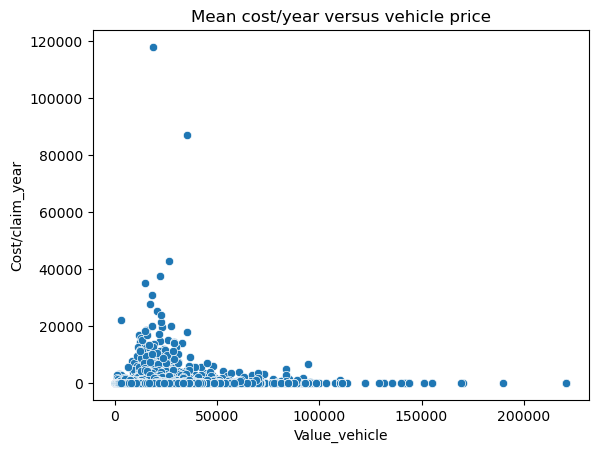

In [477]:
# are high-value vehicles a problem?

sns.scatterplot(df, x='Value_vehicle',y='Cost/claim_year').set_title("Mean cost/year versus vehicle price")
plt.show()

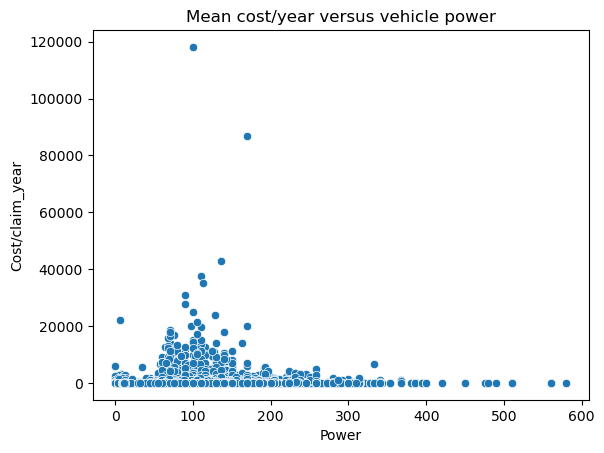

In [478]:
# are high-powered vehicles a problem?

sns.scatterplot(df, x='Power',y='Cost/claim_year').set_title("Mean cost/year versus vehicle power")
plt.show()